In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [ ]:
# ---------------------- CONFIG ----------------------
file_path = 'Sales_CG_DL_17_25.xlsx'
district = 'BILASPUR'   # <-- update as needed
mrp = 5             # <-- update as needed
target_month = '2024-03'  # <-- set target month (format: YYYY-MM)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = 12
hidden_size = 64
num_layers = 2
num_epochs = 120
lr = 0.001
batch_size = 16

In [ ]:
# ---------------------- LOAD AND PREPARE DATA ----------------------
df = pd.read_excel(file_path, sheet_name='Sheet3')
df['Billing Date'] = pd.to_datetime(df['Billing Date'])
df = df[(df['District'] == district) & (df['MRP'] == mrp)]
df = df[['Billing Date', 'Billed Quantity']]

# Fill missing dates from Apr 2017 to Dec 2024
all_dates = pd.date_range(start='2017-04-01', end='2024-12-31', freq='D')
df = df.groupby('Billing Date').sum().reindex(all_dates, fill_value=0)
df.index.name = 'Date'
df.reset_index(inplace=True)

# Aggregate to monthly
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['Billed Quantity'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].dt.to_timestamp()

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_sales[['Billed Quantity']])
series = torch.FloatTensor(scaled_data).view(-1)

In [ ]:
# ---------------------- SEQUENCE CREATION ----------------------
def create_sequences(series, seq_len):
    xs, ys = [], []
    for i in range(len(series) - seq_len):
        x = series[i:i+seq_len]
        y = series[i+seq_len]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(series, seq_len)

In [ ]:
# ---------------------- FIND TARGET INDEX ----------------------
target_timestamp = pd.to_datetime(f"{target_month}-01")
target_index = monthly_sales[monthly_sales['YearMonth'] == target_timestamp].index[0]
if target_index < seq_len:
    raise ValueError("Not enough data before the selected target month.")

X_input = series[target_index - seq_len:target_index].unsqueeze(0).to(device)
y_actual = monthly_sales.loc[target_index, 'Billed Quantity']

In [ ]:
# ---------------------- TRAINING DATA ----------------------
X_train, y_train = X[:target_index - seq_len], y[:target_index - seq_len]
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# ---------------------- LSTM MODEL ----------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # (B, T) -> (B, T, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# ---------------------- TRAIN ----------------------
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [ ]:
# ---------------------- PREDICT TARGET MONTH ----------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_input).cpu().item()

# Inverse transform
y_pred_inv = scaler.inverse_transform([[y_pred]])[0][0]

In [ ]:
# ---------------------- RESULT ----------------------
print(f"Predicted sales for {target_month}: {y_pred_inv:.2f}")
print(f"Actual sales for {target_month}: {y_actual:.2f}")
r2 = r2_score([y_actual], [y_pred_inv])
print(f"R² score: {r2:.4f}")

Epoch 0, Loss: 0.0686
Epoch 10, Loss: 0.0481
Epoch 20, Loss: 0.0083
Epoch 30, Loss: 0.0460
Epoch 40, Loss: 0.0207
Epoch 50, Loss: 0.0160
Epoch 60, Loss: 0.0166
Epoch 70, Loss: 0.0198
Epoch 80, Loss: 0.0265
Epoch 90, Loss: 0.0220
Epoch 100, Loss: 0.0117
Epoch 110, Loss: 0.0211
Predicted sales for 2024-03: 3103.67
Actual sales for 2024-03: 3069.00
R² score: nan


c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


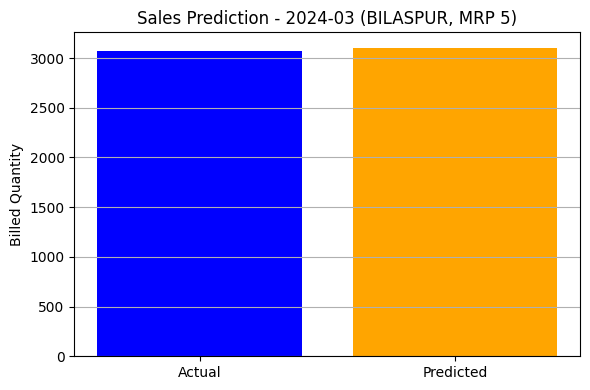

In [ ]:
# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Actual', 'Predicted'], [y_actual, y_pred_inv], color=['blue', 'orange'])
plt.title(f"Sales Prediction - {target_month} ({district}, MRP {mrp})")
plt.ylabel("Billed Quantity")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
